# House pricing on the basis of square footage and realtor assesment

Authors:
 - Nicolas Duc
 - Piotr Kula

#### Goal of this project 
The goal of this project is analysis of the market prices of houses on the basis of the square footage and the realtor's assesment.

The proposed model can be then used to asses if the given price is a good deal and to check whether the house price is comparable to the market standard.

## Data

The data was obtained from kaggle.com.

Dataset contains different types of data such as numner of bedrooms, zipcode, year it was built, we only use the square footage of the living space and the grade that the realtor has given to the house.

The dataset itself contains over 21000 records, however for the purpose of the project we sample 100 records that will later be used.

In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import random as rd
# print(len(pd.read_csv('kc_house_data.csv')))
df = (pd.read_csv("house_data_sampled.csv").sample(100)).reset_index()
# print(df.head())
# df.columns
df['price'].mean()

c:\miniconda3\envs\cmdstan\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


541517.08

In [2]:

mean_sqft_living = (df['sqft_living']).mean()
mean_grade = (df['grade']).mean()
sd_sqft_living = (df['sqft_living']).std()
print(sd_sqft_living)
print(mean_sqft_living)
sd_grade = (df['grade']).std()
sqft_living_standardized = ((df['sqft_living']).copy())
price_standardized = ((df['price']).copy())
sqft_living_centered = ((df['sqft_living']).copy())

grade_standardized = (df['grade']).copy()
print(sqft_living_standardized)
for i in range(len(df['sqft_living'])):
    sqft_living_centered[i] = ((df['sqft_living'])[i]-mean_sqft_living)
    sqft_living_standardized[i] = ((df['sqft_living'])[i]-mean_sqft_living)/sd_sqft_living
    grade_standardized[i] = (df['grade'][i]-mean_grade)/sd_grade
    price_standardized[i] = (df['price'][i]-(df['price']).mean())/(df['price']).std()
print(sqft_living_standardized.head())
print(sqft_living_standardized[0])
# print(grade_standardized)

864.2521496541493
2153.86
0     2460
1     1430
2     3490
3     2460
4     3410
      ... 
95    2240
96    1610
97    1600
98    1730
99    2330
Name: sqft_living, Length: 100, dtype: int64
0    0.354225
1   -0.837556
2    1.546007
3    0.354225
4    1.453442
Name: sqft_living, dtype: float64
0.3542253266277775


In [3]:
grade_moved = ((df['grade']).copy())
for i in range(len(grade_moved)):
    grade_moved[i] = int(grade_moved[i]-6)
print(f"MIN: {grade_moved.min()} MAX: {grade_moved.max()}")

MIN: 0 MAX: 5


In [4]:
mean_price = (df['price']).mean()
print(mean_price)

541517.08


## Model 1

### Prior

The parameters for the prior have been selected on the basis of a 

The prior has is fed 

In [66]:
sqft_linspace = np.linspace(sqft_living_centered.min(),sqft_living_centered.max())
data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace}

In [67]:
one_param_ppc_a = CmdStanModel(stan_file='CommandFiles/one_param_ppc.stan')
one_param_ppc_a_simulated = one_param_ppc_a.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:compiling stan file C:\STUFF\8th_semester\DA_project\CommandFiles\one_param_ppc.stan to exe file C:\STUFF\8th_semester\DA_project\CommandFiles\one_param_ppc.exe
INFO:cmdstanpy:compiled model executable: C:\STUFF\8th_semester\DA_project\CommandFiles\one_param_ppc.exe
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


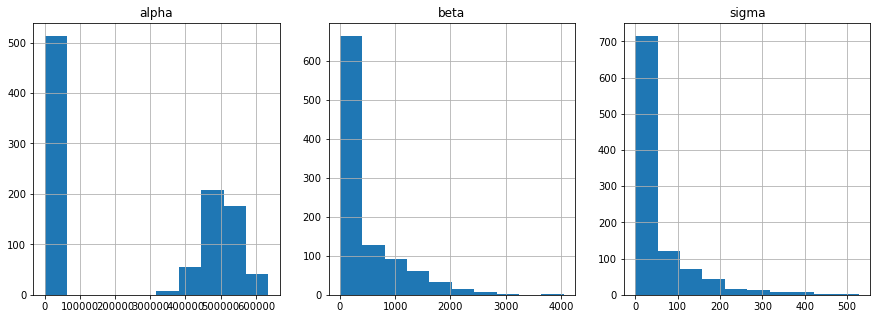

,mean,sd,hdi_3%,hdi_97%
alpha,243607.02,252656.59,0.0,560355.00
beta,393.32,592.98,0.0,1549.82
sigma,46.96,80.50,0.0,187.40


In [70]:
alpha_sim = one_param_ppc_a_simulated.stan_variable('alpha')
beta_sim = one_param_ppc_a_simulated.stan_variable('beta')
sigma_sim = one_param_ppc_a_simulated.stan_variable('sigma')
price_sim = one_param_ppc_a_simulated.stan_variable('price')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim);
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sim);
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(sigma_sim);
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(one_param_ppc_a_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

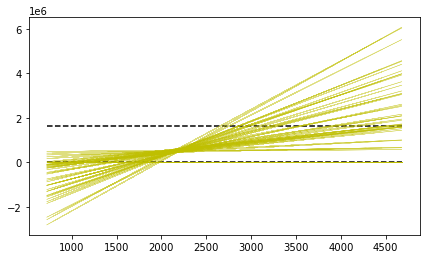

In [71]:
alpha_sim=one_param_ppc_a_simulated.stan_variable('alpha')
beta_sim=one_param_ppc_a_simulated.stan_variable('beta')

# plt.plot(beta_sim)
# plt.title("grade")
# plt.show()
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([0,(df['price']).max()],xmin=df['sqft_living'].min(),xmax=df['sqft_living'].max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(df['sqft_living'],alpha_sim[i]+beta_sim[i]*sqft_living_centered, color = 'y',alpha=0.5,linewidth=0.5)

## Model 1 Posterior

In [12]:
data = {'N': len(sqft_living_centered),
        'sqft': sqft_living_centered,
        'price': df['price']}
one_param = CmdStanModel(stan_file='CommandFiles/one_param.stan')
one_param_simulated = one_param.sample(data=data, seed=21370204)

INFO:cmdstanpy:compiling stan file C:\STUFF\8th_semester\DA_project\CommandFiles\one_param.stan to exe file C:\STUFF\8th_semester\DA_project\CommandFiles\one_param.exe
INFO:cmdstanpy:compiled model executable: C:\STUFF\8th_semester\DA_project\CommandFiles\one_param.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/STUFF/8th_semester/DA_project/CommandFiles/one_param.hpp C:/STUFF/8th_semester/DA_project/CommandFiles/one_param.stan
Warning in 'C:/STUFF/8th_semester/DA_project/CommandFiles/one_param.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/STUFF/8th_semester/DA_project/CommandFiles/one_param.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 


INFO:cmdstanpy:CmdStan done processing.


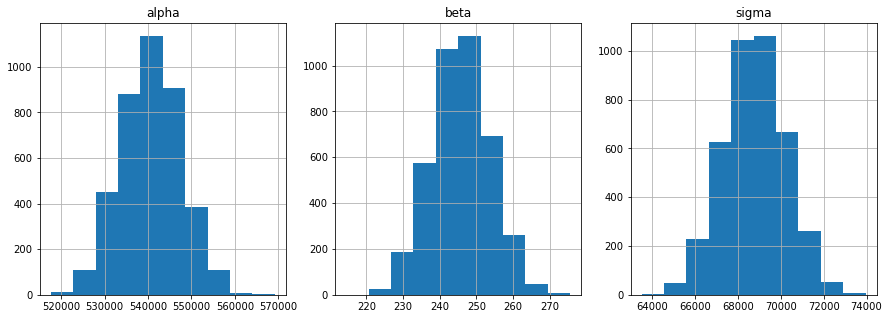

,mean,sd,hdi_3%,hdi_97%
alpha,540735.27,6903.63,527817.00,553643.00
beta,245.73,7.96,230.46,259.87
sigma,68771.90,1434.28,66119.40,71400.40


In [13]:
alpha_sim = one_param_simulated.stan_variable('alpha')
beta_sim = one_param_simulated.stan_variable('beta')
sigma_sim = one_param_simulated.stan_variable('sigma')
price_sim = one_param_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sim)
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(sigma_sim)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(one_param_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

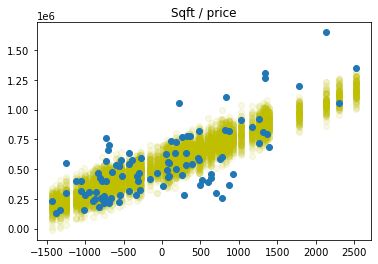

In [14]:
prices_sim=one_param_simulated.stan_variable('price_sim')

# for i in range(0,len(df['sqft_living'])):
for i in range(100):
    plt.scatter(sqft_living_centered, prices_sim[i], color="y", alpha=0.1)

plt.scatter(sqft_living_centered, df["price"])

plt.title("Sqft / price")
plt.show()

## Adding second predictor to model

### Prior predictive check

In [113]:
sqft_linspace = np.linspace(sqft_living_standardized.min(),sqft_living_standardized.max())
grade_in = grade_moved.sample(50).sort_values()
# print(grade_in)

data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace,
        'grade': grade_in}
two_params_ppc = CmdStanModel(stan_file='CommandFiles/two_param_discrete_ppc.stan')
two_params_ppc_simulated = two_params_ppc.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [75]:
sqft_linspace = np.linspace(sqft_living_standardized.min(),sqft_living_standardized.max())
grade_linspace = np.linspace(grade_standardized.min(),grade_standardized.max())

data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace,
        'grade': grade_linspace}
two_params_ppc = CmdStanModel(stan_file='CommandFiles/two_params_ppc.stan')
two_params_ppc_simulated = two_params_ppc.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


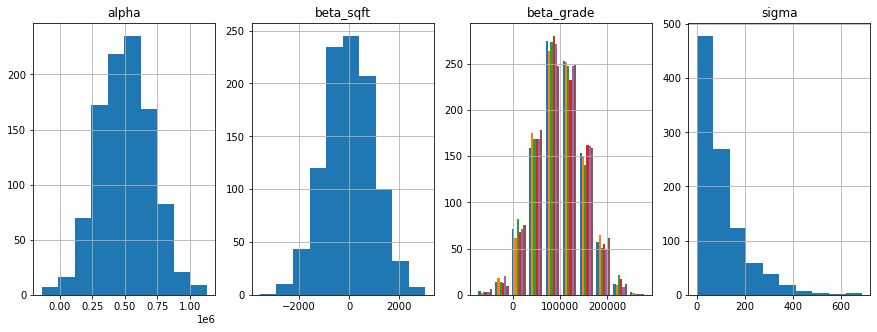

,mean,sd,hdi_3%,hdi_97%
alpha,501428.90,204163.00,117631.00,857553.00
beta_sqft,5.80,987.08,-1952.94,1813.33
beta_grade[0],99792.74,50240.58,12582.10,196069.00
beta_grade[1],100178.95,50780.82,12716.50,198742.00
beta_grade[2],98223.72,51154.15,-2179.99,189383.00
beta_grade[3],100249.85,50445.28,1952.61,193218.00
beta_grade[4],97744.86,49496.68,-6254.87,180473.00
beta_grade[5],99564.32,50678.19,12032.60,192234.00
sigma,102.66,100.56,0.01,289.53


In [114]:
alpha_sim = two_params_ppc_simulated.stan_variable('alpha')
beta_grade_sim = two_params_ppc_simulated.stan_variable('beta_grade')
beta_sqft_sim = two_params_ppc_simulated.stan_variable('beta_sqft')
sigma_sim = two_params_ppc_simulated.stan_variable('sigma')
# price_sim = two_params_ppc_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,4)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sqft_sim)
axs[1].grid()
axs[1].set_title('beta_sqft')
axs[2].hist(beta_grade_sim)
axs[2].grid()
axs[2].set_title('beta_grade')
axs[3].hist(sigma_sim)
axs[3].grid()
axs[3].set_title('sigma')
plt.show()

az.summary(two_params_ppc_simulated,var_names=['alpha','beta_sqft', 'beta_grade','sigma'],round_to=2,kind='stats')

In [18]:
data = {'N': len(sqft_living_standardized),
        'sqft_living': sqft_living_standardized,
        'grade': grade_moved,
        'price': price_standardized}
two_params_discrete = CmdStanModel(stan_file='CommandFiles/two_param_discrete.stan')
two_params_simulated_discrete = two_params_discrete.sample(data=data, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:03 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:04 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:04 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:05 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:06 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:06 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:07 Iteration


INFO:cmdstanpy:CmdStan done processing.


In [20]:
data = {'N': len(sqft_living_standardized),
        'sqft_living': sqft_living_standardized,
        'grade': grade_standardized,
        'price': price_standardized}
two_params = CmdStanModel(stan_file='CommandFiles/two_params.stan')
two_params_simulated = two_params.sample(data=data, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


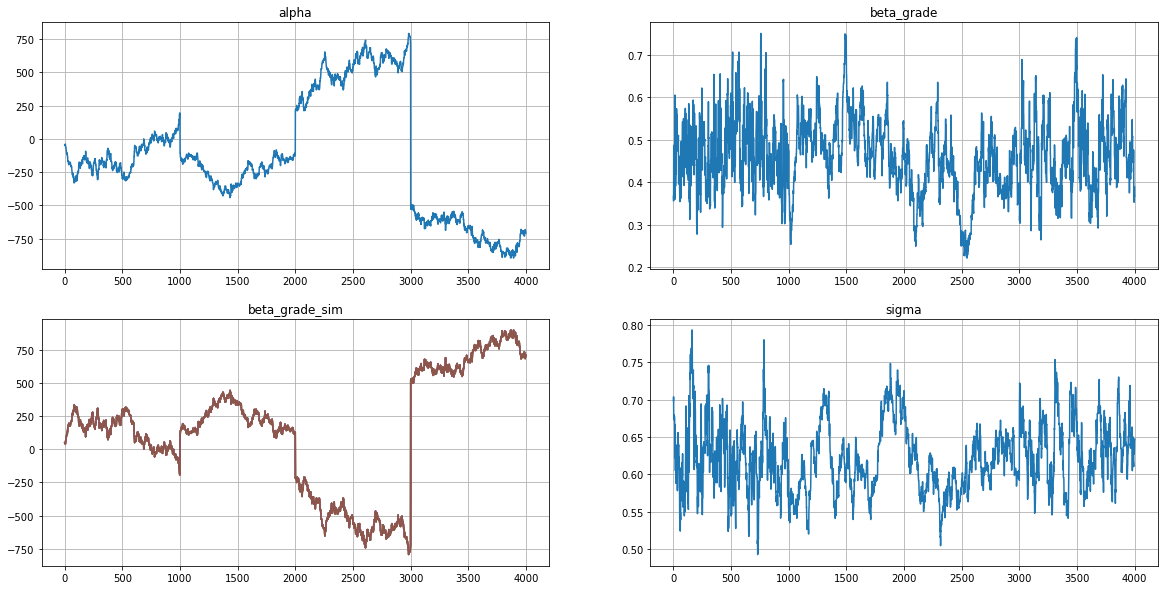

,mean,sd,hdi_3%,hdi_97%
alpha,-136.21,445.45,-814.88,668.75
beta_sqft_living,0.46,0.09,0.29,0.62
beta_grade[0],135.64,445.48,-670.00,813.83
beta_grade[1],136.03,445.47,-669.08,814.56
beta_grade[2],136.21,445.45,-668.72,814.88
beta_grade[3],136.34,445.43,-668.53,815.13
beta_grade[4],137.72,445.41,-666.99,816.77
beta_grade[5],137.20,445.42,-668.16,815.50
sigma,0.62,0.05,0.55,0.71


In [9]:
alpha_sim = two_params_simulated.stan_variable('alpha')
beta_living_sim = two_params_simulated.stan_variable('beta_sqft_living')
beta_grade_sim = two_params_simulated.stan_variable('beta_grade')
sigma_sim = two_params_simulated.stan_variable('sigma')
price_sim = two_params_simulated.stan_variable('prices')

fig, axs = plt.subplots(2,2)
fig.set_size_inches(20, 10)
axs[0][0].plot(alpha_sim)
axs[0][0].grid()
axs[0][0].set_title('alpha')
axs[0][1].plot(beta_living_sim)
axs[0][1].grid()
axs[0][1].set_title('beta_grade')
axs[1][0].plot(beta_grade_sim)
axs[1][0].grid()
axs[1][0].set_title('beta_grade_sim')
axs[1][1].plot(sigma_sim)
axs[1][1].grid()
axs[1][1].set_title('sigma')
plt.show()

az.summary(two_params_simulated,var_names=['alpha','beta_sqft_living', 'beta_grade','sigma'],round_to=2,kind='stats')

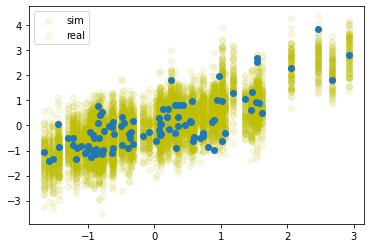

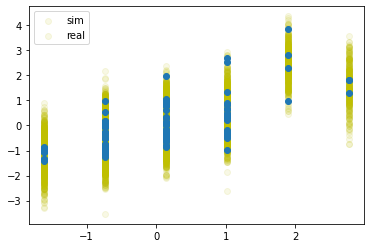

In [10]:
price_sim = two_params_simulated.stan_variable('prices')


for i in range(100):
    plt.scatter(sqft_living_standardized, price_sim[i], color="y", alpha=0.1)

plt.scatter(sqft_living_standardized,price_standardized)
plt.legend(["sim", "real"])
plt.show()

for i in range(100):
    plt.scatter(grade_standardized, price_sim[i], color="y", alpha=0.1)
plt.scatter(grade_standardized,price_standardized)
plt.legend(["sim", "real"])



In [21]:
# Comparing 2 models: model_1 - with AGE only, model_2 - with AGE and BMI
idata1 = az.from_cmdstanpy(posterior = one_param_simulated, log_likelihood = "log_lik")
idata2 = az.from_cmdstanpy(posterior = two_params_simulated, log_likelihood = "log_lik")
idata3 = az.from_cmdstanpy(posterior=two_params_simulated_discrete, log_likelihood="log_lik") 
compare_dict = {"one_param_model": idata1, "two_param_model": idata2, "two_param_discrete": idata3}

out_loo = az.compare(compare_dict, ic = "loo")
out_waic = az.compare(compare_dict, ic = "waic") # loo stands for leave one out cross validation

c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\sta

In [23]:
# Comparing 2 models: model_1 - with AGE only, model_2 - with AGE and BMI
idata2 = az.from_cmdstanpy(posterior = two_params_simulated, log_likelihood = "log_lik")
idata3 = az.from_cmdstanpy(posterior=two_params_simulated_discrete, log_likelihood="log_lik") 
compare_dict = {"two_param_model": idata2, "two_param_discrete": idata3}

out_loo = az.compare(compare_dict, ic = "loo")
out_waic = az.compare(compare_dict, ic = "waic") # loo stands for leave one out cross validation

c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\cmdstan\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\miniconda3\envs\cmdstan\lib\site-packag

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
two_param_discrete,0,-99.979261,8.668769,0.000000,0.55937,8.685397,0.000000,False,log
two_param_model,1,-100.917468,4.617652,0.938207,0.44063,8.754549,4.543933,False,log
one_param_model,2,-1614.069716,27.745220,1514.090454,0.00000,65.403271,58.573152,True,log


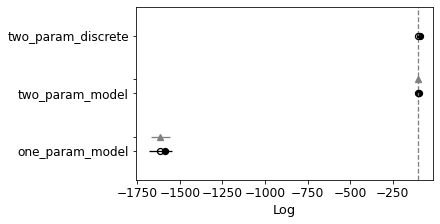

In [22]:
az.plot_compare(out_loo)
out_loo


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
two_param_discrete,0,-99.979261,8.668769,0.000000,0.559463,8.685397,0.000000,False,log
two_param_model,1,-100.917468,4.617652,0.938207,0.440537,8.754549,4.543933,False,log


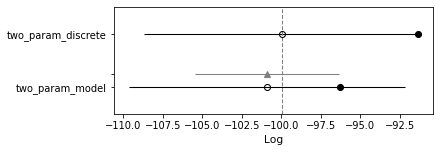

In [24]:
az.plot_compare(out_loo)
out_loo

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
two_param_model,0,-99.745539,8.435046,0.000000,1.000000e+00,8.658074,0.000000,True,log
one_param_model,1,-1614.114163,27.789668,1514.368625,1.158639e-09,65.436963,58.632821,True,log


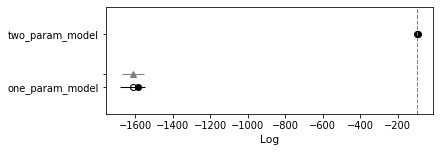

In [17]:
az.plot_compare(out_waic)
out_waic


1. The warnings are most likey caused by the outliers in the data: https://discourse.mc-stan.org/t/number-of-points-with-pareto-k-0-7-increases-when-a-subset-of-the-data-set-is-used/91081.